### Описание эксперимента

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом.  

Описание колонок:  
`value` – значения метрики  
`experimentVariant` – Вариант теста (Control – контроль, Treatment – тест)

### Задача

1. Сравните результат между тестом и контролем по двум кейсам:  
    - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
    - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.


2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt

In [2]:
# прочитаем данные, указав десятичный разделитель ',' и разделитель колонок - ';'
df = (
    pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', 
                 decimal=',', 
                 sep=';')
            .drop('Unnamed: 0', axis=1)          # удалим ненужную колонку
     )        

In [3]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [4]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [5]:
df.shape

(1000, 2)

In [6]:
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [7]:
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [8]:
# разделим данные на контрольную и тестовую группы
control = df.query('experimentVariant == "Control"').value
test    = df.query('experimentVariant == "Treatment"').value

In [9]:
# напишем функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой выборки
    data_column_2,                       # числовые значения второй выборки
    boot_it = 1000,                      # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95          # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

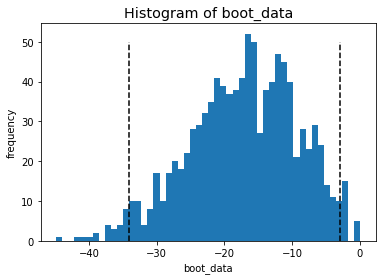

In [10]:
# бутстрап (с np.mean)
booted_data_mean = get_bootstrap(control, test, statistic = np.mean)

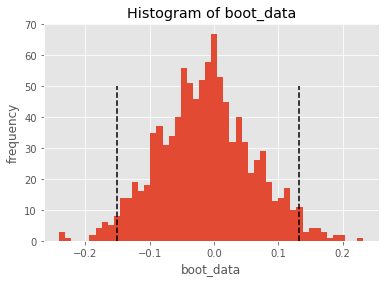

In [11]:
# бутстрап (с np.median)
booted_data_median = get_bootstrap(control, test, statistic = np.median)

In [12]:
# бутстрап (с np.mean), p-value
booted_data_mean['p_value']

0.030940862313839888

In [13]:
# критерий mann-whitney,
mannwhitneyu(control, test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [14]:
# бутстрап (с np.median), p-value
booted_data_median['p_value']

0.8651485804696982

P-value при использовании бутстрапа с np.mean   < 0.05, что позволило бы отклонить нулевую гипотезу и принять альтернативную - различия между контрольной и тестовой группой статистически значимы.  
Однако, P-value при использовании бутстрапа с np.median и при использовании критерия Манна-Уитни значительно больше 0.05, возникает противоречие.

Посмотрим на распределения тестовой и контрольной групп.

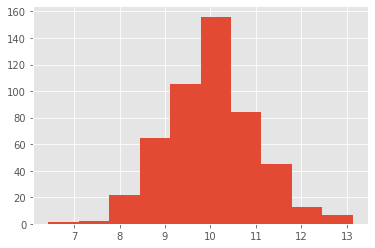

In [15]:
# распределение контрольной группы
control.hist()

In [16]:
# тест Шапиро-Уилка для контрольной группы
shapiro(control)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

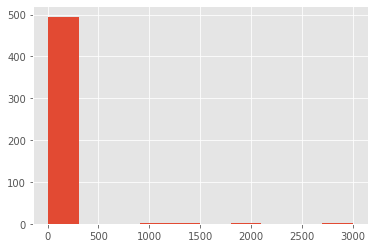

In [17]:
# распределение тестовой группы
test.hist()

In [18]:
# тест Шапиро-Уилка для тестовой группы
shapiro(test)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

Итак, контрольная группа имеет нормальное распределение, тестовая - нет.

Посмотрим, как будет выглядеть распределения тестовой группы, если отобрать значения <= максимальному из контрольной группы.

In [19]:
# максимальное значение контрольной группы
control_max = control.max()

In [20]:
# тестовый набор данных без выбросов
test_no_outliers = test[test <= control_max]

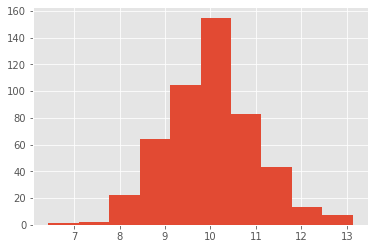

In [21]:
test_no_outliers.hist()

In [22]:
shapiro(test_no_outliers)

ShapiroResult(statistic=0.9955515265464783, pvalue=0.17188233137130737)

In [25]:
# выбросы в тестовом наборе данных
test[test > control_max]

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

Выходит, что тестовый набор данных тоже имеет нормальное распределение, но это дело портят значительные выбросы.

Снова проведём бутстрап, но уже с использованием тестовых данных без выбросов.

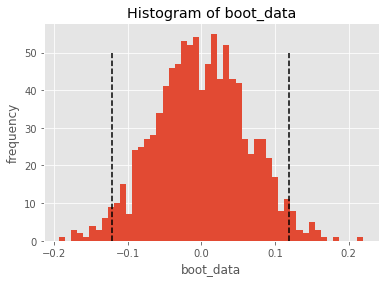

In [23]:
# бутстрап (с np.mean) с тестовыми данными без выбросов
booted_no_outliers_mean = get_bootstrap(control, test_no_outliers, statistic = np.mean)

In [24]:
booted_no_outliers_mean['p_value']

0.9966954472007391

В результате при при бутстрапе с функцией np.mean получаем значение P-value очень близкое к значению при использовании функции np.median.   

Выводы, которые можно сделать: 
1. Бутстрап с функцией np.mean чувствителен к выбросам в данных.    
2. Бутстрап с функцией np.median и критерий Манна-Уитни не чувствительны к выбросам в данных.  
3. Принимаем нулевую гипотезу - статистически значимых различий между тестовой и контрольной групп нет.